In [9]:
import torch
import torchvision
import glob
import cv2
import PIL
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
from IPython.display import Image

In [10]:
# read all the frames from the folder 'data/frames'
paths = glob.glob('../data/extracted/video_1/*.jpg')
paths.sort()
frames = [PIL.Image.open(path) for path in paths]
# convert to RGB
frames = [frame.convert('RGB') for frame in frames]



In [11]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [12]:
batch_images = torch.stack([transforms(frame) for frame in frames])
print(batch_images.shape)

torch.Size([114, 3, 224, 224])


In [13]:
# extract the features from the images using ResNet50
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.eval();

# create a model that returns the features of the last layer, and add global average pooling
model  = torch.nn.Sequential(*list(resnet50.children())[:-1])
model.eval()
with torch.no_grad():
    features = model(batch_images).squeeze()
print(features.shape)

/raid/home/labuserterbouche/.cache/pypoetry/virtualenvs/video-recover-DnP1VpAc-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/raid/home/labuserterbouche/.cache/pypoetry/virtualenvs/video-recover-DnP1VpAc-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([114, 2048])


In [14]:
# use anomaly detection to find the noisy frames
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, n_estimators=120).fit(features)
print(clf.predict(features))

[ 1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1]


In [15]:
# get the number of noisy frames
print(np.count_nonzero(clf.predict(features) == -1))

14


In [16]:
# get the indices of the noisy frames
noisy_frames_indices = np.where(clf.predict(features) == -1)[0]

In [17]:
print(noisy_frames_indices)

[ 10  17  36  42  46  69  73  76  78  83  88  90 100 101]


In [18]:
# define true paths
true_paths = [path for i, path in enumerate(paths) if i not in noisy_frames_indices]

In [19]:
# define true features
true_features = features[clf.predict(features) == 1]

In [20]:
# cluster the true features
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0,n_init="auto").fit(true_features)
print(kmeans.labels_)



[7 0 1 4 0 1 2 9 8 0 8 1 1 4 0 7 0 3 0 3 0 0 3 7 8 6 7 3 0 9 0 5 2 4 5 3 6
 2 4 6 1 1 2 8 0 8 0 0 8 0 8 1 2 7 0 6 4 4 6 0 8 0 1 4 5 6 0 2 6 1 0 7 8 5
 8 7 7 1 5 8 4 0 8 8 1 8 2 2 2 1 0 5 0 6 4 4 2 2 9 3]


In [21]:
# get the indices of the frames in each cluster
cluster_indices = []
for i in range(10):
    cluster_indices.append(np.where(kmeans.labels_ == i)[0])


In [22]:
# get the size of each cluster
cluster_sizes = [len(indices) for indices in cluster_indices]
print(cluster_sizes)

[22, 12, 11, 6, 10, 6, 8, 8, 14, 3]


In [23]:
# convert the indices to paths
cluster_paths = []
for cluster in cluster_indices:
    cluster_paths.append([true_paths[index] for index in cluster])


In [24]:
print(cluster_paths[-1])

['../data/extracted/video_1/0000007.jpg', '../data/extracted/video_1/0000031.jpg', '../data/extracted/video_1/0000112.jpg']


In [25]:
# compute the t-SNE embedding of the features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
embeddings = tsne.fit_transform(features)
print(embeddings.shape)

(114, 2)


In [26]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import plot
init_notebook_mode(connected=True)

from IPython.display import Image

# create the scatter plot
trace = go.Scatter(
    x=embeddings[:, 0],
    y=embeddings[:, 1],
    mode='markers',
    text=[path for path in paths],
    hoverinfo='text',
    marker=dict(
        size=10,
        color='blue',
        symbol='circle',
        line=dict(
            width=2,
            color='DarkSlateGrey'
        )
    )
)

# create the layout
layout = go.Layout(
    xaxis=dict(title='X'),
    yaxis=dict(title='Y'),
    hovermode='closest',
    showlegend=False
)

# create the scatter plot figure
fig = go.Figure(data=[trace], layout=layout)

# create a function to display the image when a point is clicked
def show_image(trace, points, state):
    ind = points.point_inds[0]
    img = Image(paths[ind])
    display(img)

# add the click event to the scatter plot
fig.data[0].on_click(show_image)

# show the scatter plot
#plot(fig, filename='scatter_with_images.html')
fig.show()

In [27]:
img1 = cv2.imread(paths[0], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(paths[1], cv2.IMREAD_GRAYSCALE)
# Initiate SIFT detector
sift = cv2.SIFT_create()

In [28]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [29]:

img=cv2.drawKeypoints(img1,kp1,img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

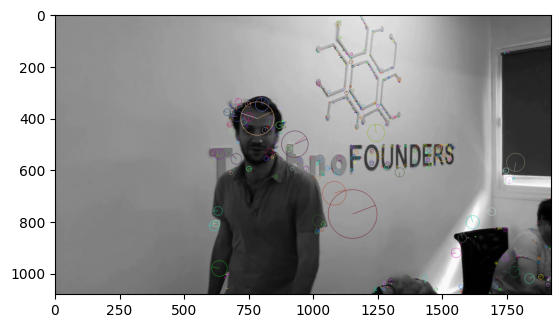

(<matplotlib.image.AxesImage at 0x7f4673b07fd0>, None)

In [30]:
plt.imshow(img),plt.show()

In [31]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des2,des1, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
        

In [34]:
for match in good:
    # Get the coordinates of the matching features in each image
    print(match.queryIdx, match.trainIdx, match.imgIdx, match.distance)
    x1, y1 = kp1[match.queryIdx].pt
    x2, y2 = kp2[match.trainIdx].pt
    break

0 2 0 229.492919921875


In [36]:
for m,n in matches:
    print(m.distance, n.distance)
    break

229.492919921875 365.3299865722656


In [37]:

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [38]:
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

good = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)


In [39]:
len(matchesMask), len(good)

(581, 158)

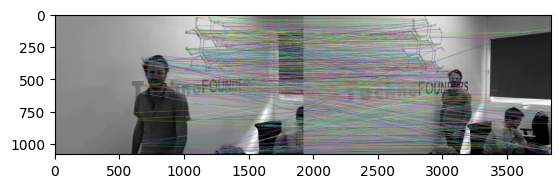

(<matplotlib.image.AxesImage at 0x7f45bcd814c0>, None)

In [41]:
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [ ]:
noisy_images_indices = [10, 17, 36, 42, 46, 69, 73, 76, 78, 83, 88, 90, 100, 101]
true_paths = [paths[i] for i in range(len(paths)) if i not in noisy_images_indices]